# Loading Data

In [1]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# Pre-processing

1) Relpace punctuation with tokenized words

2) Split the data by words

3) Remove words that appear less than six times

4) Sort the words from least to most frequent

5) Create an input embedding layer ('the': '0')

6) Create an output embedding layer ('0': 'the')

In [5]:
import re
from collections import Counter

def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [4]:
# get list of words
words = preprocess(text)
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words in text: 16680599
Unique words: 63641


In [6]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [8]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

# Subsampling

For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

In [9]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [16]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [18]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

# Validation

In [19]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

# Skip Gram Negative Sampling Implementation of Word2Vec Algorithm

In [21]:
import torch
from torch import nn
import torch.optim as optim

# Custom Loss function
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize embedding tables with uniform distribution
        # I believe this helps with convergence
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
        
        return noise_vectors

# Training

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

km
discovered | vanish, ancestry, smilga, sommerfeld, french
institute | keaton, four, pd, nine, with
san | milius, hireling, le, agincourt, pharaoh
universe | thereupon, antioxidant, natural, finally, bulwer
...

Epoch: 1/5
Loss:  4.1010212898254395
some | a, as, in, and, of
no | the, an, that, for, a
seven | one, five, zero, six, nine
three | two, five, zero, seven, one
about | zero, as, two, they, are
more | be, their, as, or, this
four | nine, one, six, zero, five
most | are, in, it, of, with
know | may, a, misses, lifes, imagesize
brother | dione, as, preferring, charters, ecmascript
freedom | living, alone, injection, moabite, digraph
mean | power, lecturer, alphorn, summertime, order
primarily | passport, electrical, mirror, hence, redemption
mathematics | uncia, turk, czapski, medford, tries
lived | had, tombs, sequenced, jarre, bridged
articles | organically, novel, theorize, their, toe
...

Epoch: 1/5
Loss:  3.615694999694824
other | as, a, in, of, the
b | one, nine, four, d,

# Visualize Results

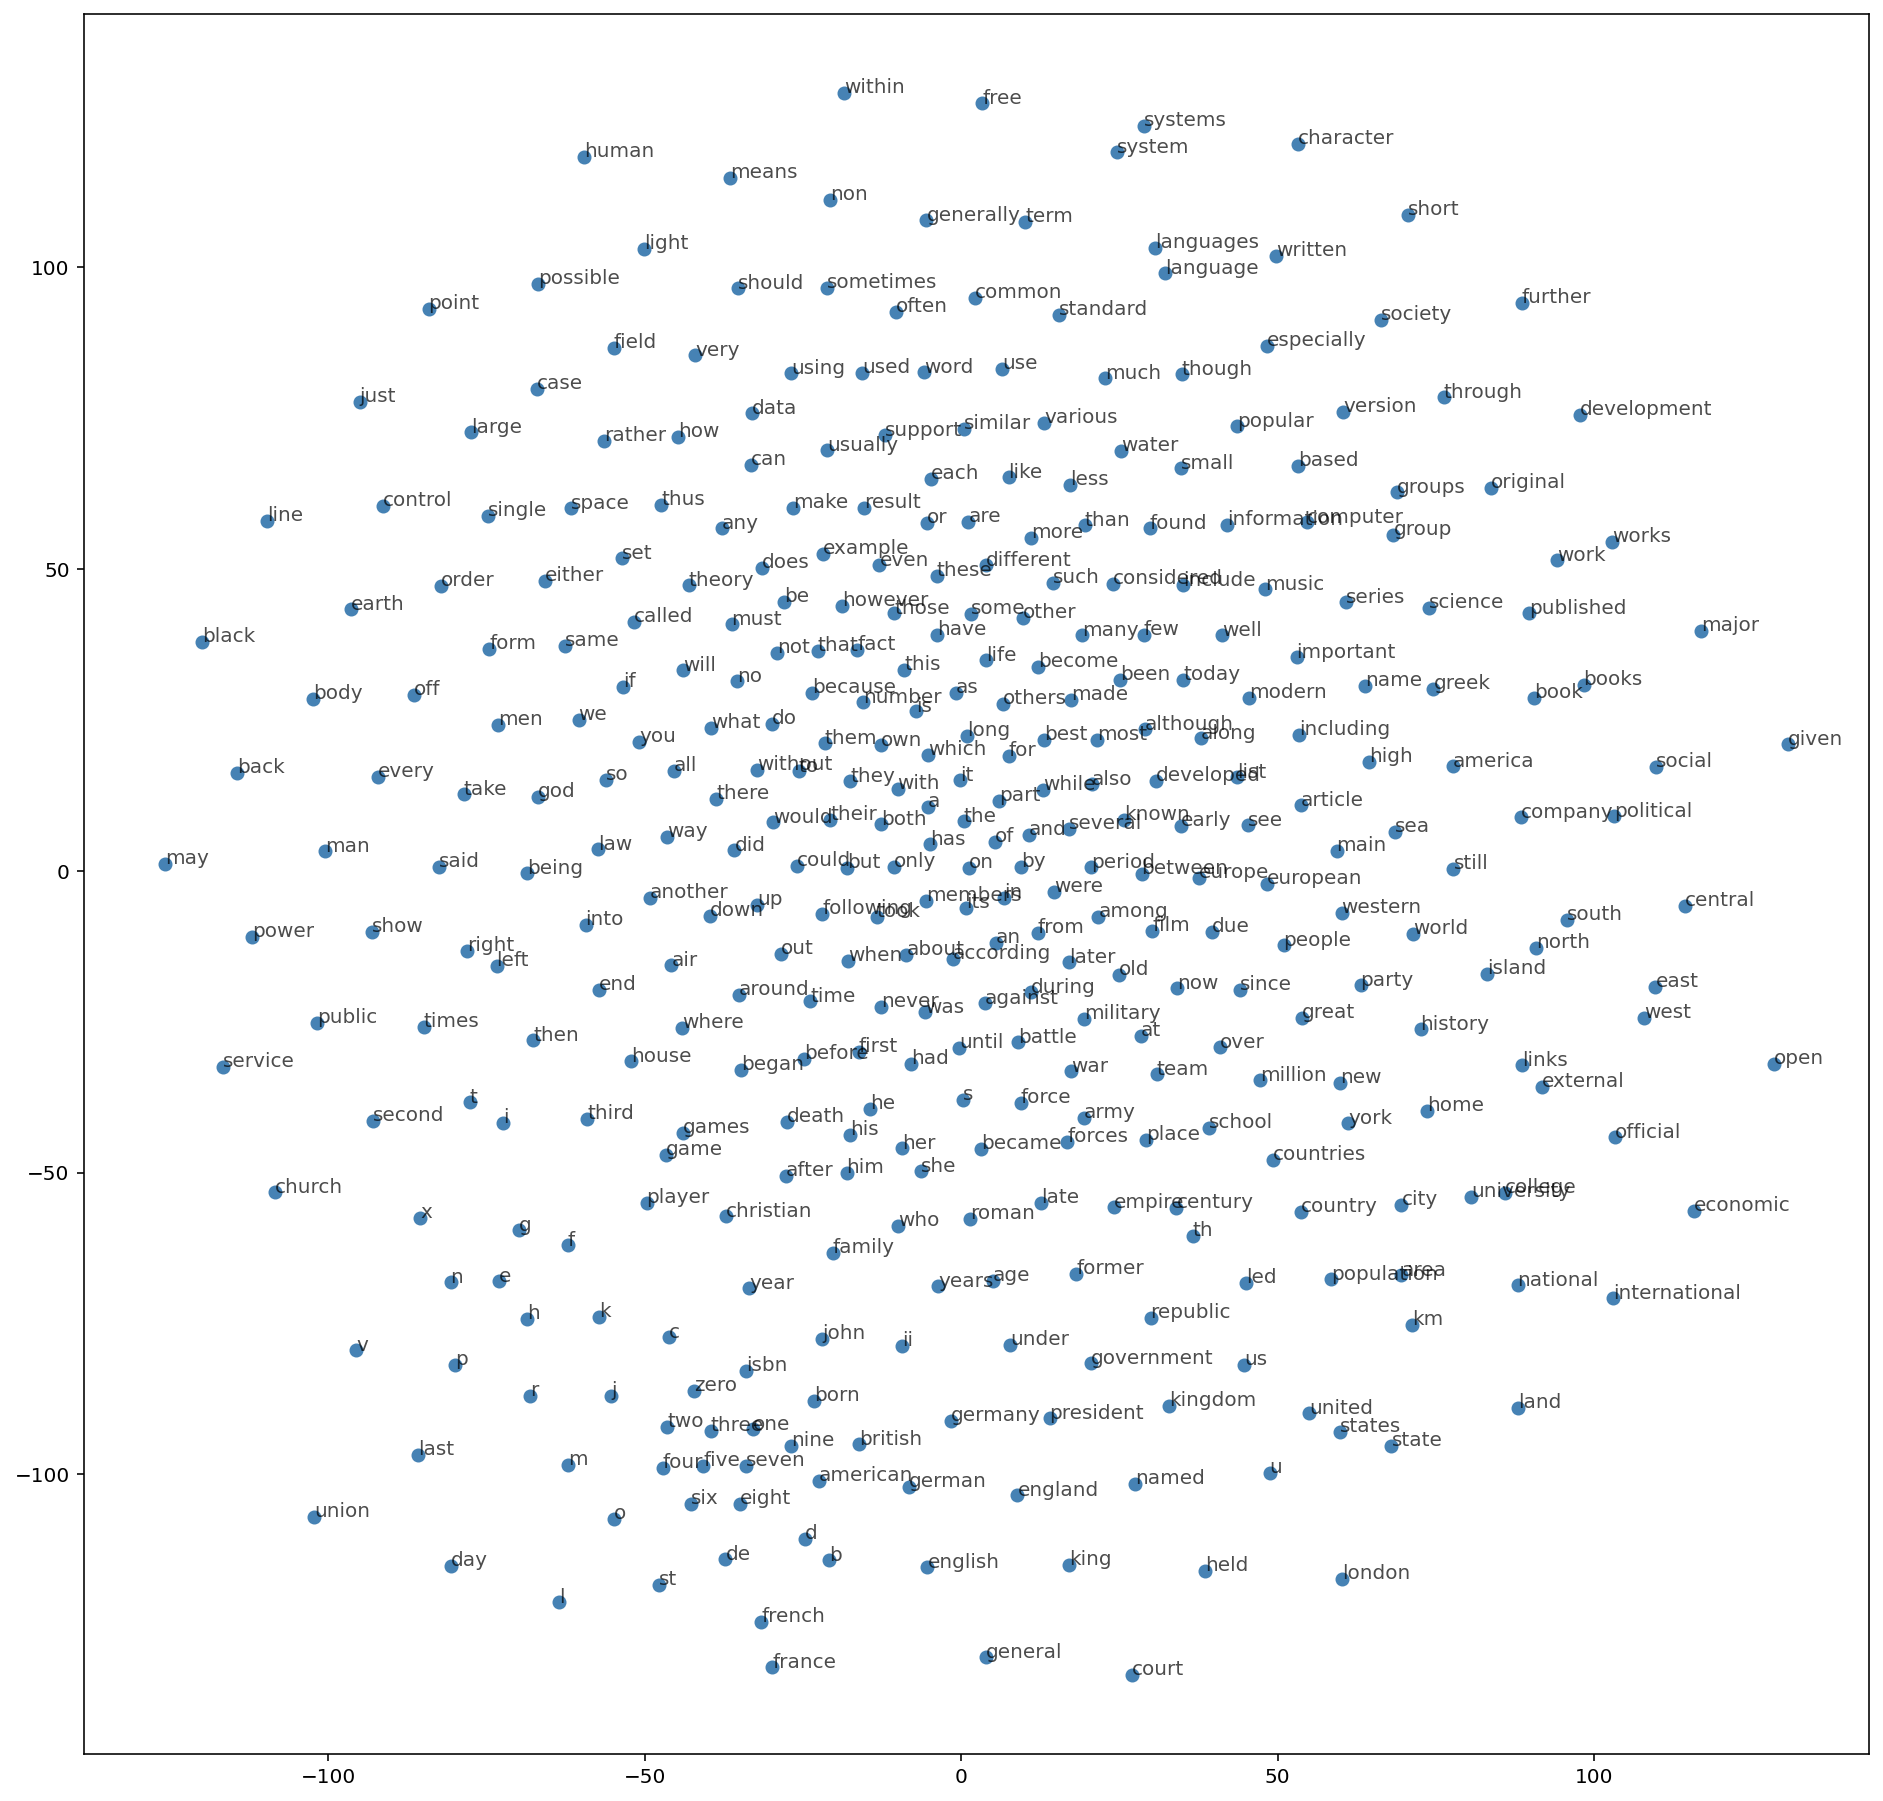

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)